In [ ]:
## Importing the required libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn.datasets import load_files   
from tqdm import tqdm
from collections import Counter

In [ ]:
## checking keras version
print(keras.__version__)

2.8.0


# Data Reading/Data Understanding

In [ ]:
## Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Setting the path for my train and test dataset from google drive
base_path = '/content/drive/MyDrive/Colab_Notebooks/Datasets'
data_train = pathlib.Path(base_path + '/Train')
data_test = pathlib.Path(base_path + '/Test')

In [ ]:
## Checking the count of images
image_count_train = len(list(data_train.glob('*/*.jpg')))
print("Train images count is : ", image_count_train)
image_count_test = len(list(data_test.glob('*/*.jpg')))
print("Test images count is : ", image_count_test)

Train images count is :  2239
Test images count is :  118


## Creating datasets
  * Load using keras.preprocessing
  * Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [ ]:
## Defining parameters for all the models
batch_size = 32
img_height = 180
img_width = 180

### Creating our train and validation dataset from train in the ration 80:20

In [ ]:
## Creating train dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
##  Creating validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
## creating test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [ ]:
## Listing out the categories present in the dataset
class_names = train_dataset.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Data Visualization

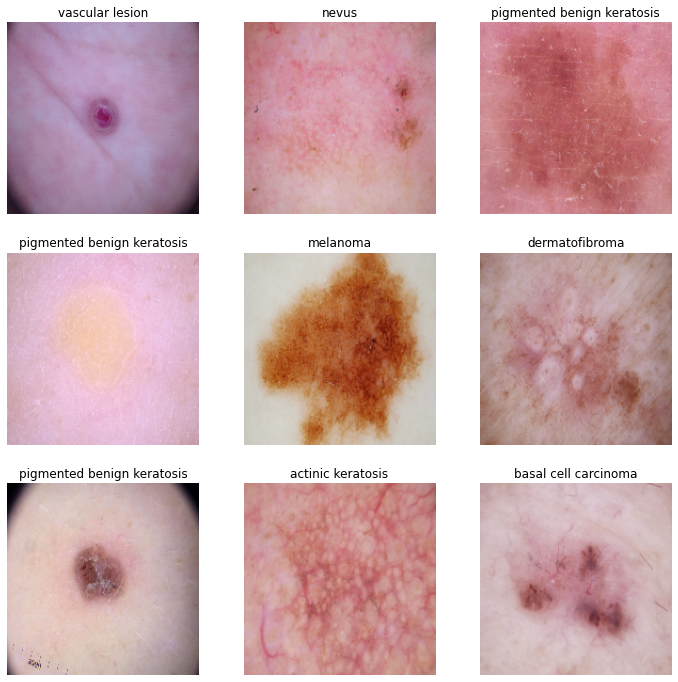

In [ ]:
## function to create the visualization
def visual():
  plt.figure(figsize=(12, 12)) ##using square dimension for better picture visibility
  for images, labels in train_dataset.take(1):
    for i in range(len(class_names)):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")
visual()

In [ ]:
## checking the tensor shape
for images, labels in train_dataset:
  print("Tensor of the Images are of dimension : ", images.shape)
  print("Tensor of the Labels are of dimension : ", labels.shape)
  break

Tensor of the Images are of dimension :  (32, 180, 180, 3)
Tensor of the Labels are of dimension :  (32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

### Standardizing data
##### Since RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]
* we will use **layers.experimental.preprocessing.Rescaling** to normalize the pixel values

## Creating our first model

In [ ]:
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())


model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

## Compile the Model

In [ ]:
## creating function to compile model using "adam" as optimizer and "SparseCategoricalCrossentropy" to calculate loss
def compile_model():
  model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
compile_model()

In [ ]:
## displaying model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_35 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_36 (ModuleWr  (None, 180, 180, 32)     0         
 apper)                                                          
                                                                 
 module_wrapper_37 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                                 
 module_wrapper_38 (ModuleWr  (None, 90, 90, 32)       9248      
 apper)                                               

## Training the Model

In [ ]:
## training for 20 epochs
model_train = model.fit(
  train_dataset,
  batch_size=batch_size,
  validation_data=val_dataset,
  epochs=20
)

Epoch 1/20
56/56 [==============================] - 259s 4s/step - loss: 1.9182 - accuracy: 0.2812 - val_loss: 1.6819 - val_accuracy: 0.4318
Epoch 2/20
56/56 [==============================] - 14s 226ms/step - loss: 1.6357 - accuracy: 0.4051 - val_loss: 1.6074 - val_accuracy: 0.4609
Epoch 3/20
56/56 [==============================] - 14s 225ms/step - loss: 1.4741 - accuracy: 0.4833 - val_loss: 1.4718 - val_accuracy: 0.4989
Epoch 4/20
56/56 [==============================] - 14s 222ms/step - loss: 1.3371 - accuracy: 0.5312 - val_loss: 1.3325 - val_accuracy: 0.5391
Epoch 5/20
56/56 [==============================] - 14s 224ms/step - loss: 1.1992 - accuracy: 0.5815 - val_loss: 1.3122 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 14s 222ms/step - loss: 1.1234 - accuracy: 0.5932 - val_loss: 1.3452 - val_accuracy: 0.5459
Epoch 7/20
56/56 [==============================] - 16s 251ms/step - loss: 1.0628 - accuracy: 0.6166 - val_loss: 1.3133 - val_accuracy: 0.5459
E

## Visualizing training results

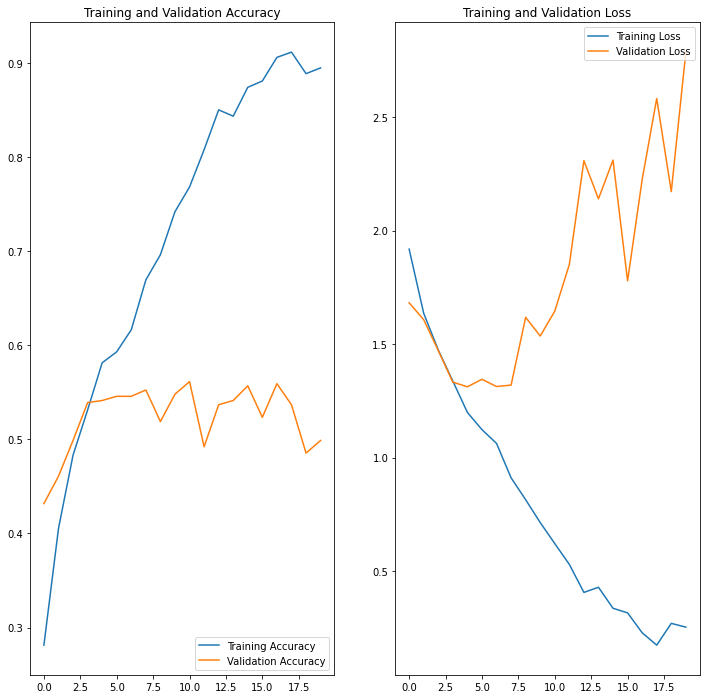

In [ ]:
## plotting validation loss/accuracy with training loss/accuracy
def validation_training():
  epochs=20
  acc = model_train.history['accuracy']
  val_acc = model_train.history['val_accuracy']

  loss = model_train.history['loss']
  val_loss = model_train.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(12, 12))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
validation_training()

In [ ]:
## Evaluating our model
def evaluate():
  loss, accuracy = model.evaluate(train_dataset, verbose=1,)
  loss_val, accuracy_val = model.evaluate(val_dataset, verbose=1)

  print("Train Dataset Accuracy: ", accuracy)
  print("Validation Dataset Accuracy: ",accuracy_val)
  print("Train Dataset Loss: ",loss)
  print("Validation Dataset Loss", loss_val)
evaluate()

14/14 [==============================] - 3s 75ms/step - loss: 2.7857 - accuracy: 0.4989
Train Dataset Accuracy:  0.9263392686843872
Validation Dataset Accuracy:  0.49888142943382263
Train Dataset Loss:  0.17122654616832733
Validation Dataset Loss 2.7856500148773193


### Conclusion model 1
#### We can clearly see that the model is an overfit as the training accuracy is greater than validation accuracy

#### In order to fix overfitting let's tweak/augment our data by using imagedatagenerator library.

In [ ]:
augmentdata = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.10, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)
## augmenting the data in the train directory
train_batches = augmentdata.flow_from_directory(data_train, 
    target_size = (180,180),
    classes = class_names,
    batch_size = 32
 )
## augmenting the data in the test directory
valid_batches = augmentdata.flow_from_directory(data_test, 
    target_size = (180,180),
    classes = class_names,
    batch_size = 32
)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


#### Let's visualize the date after augmentation

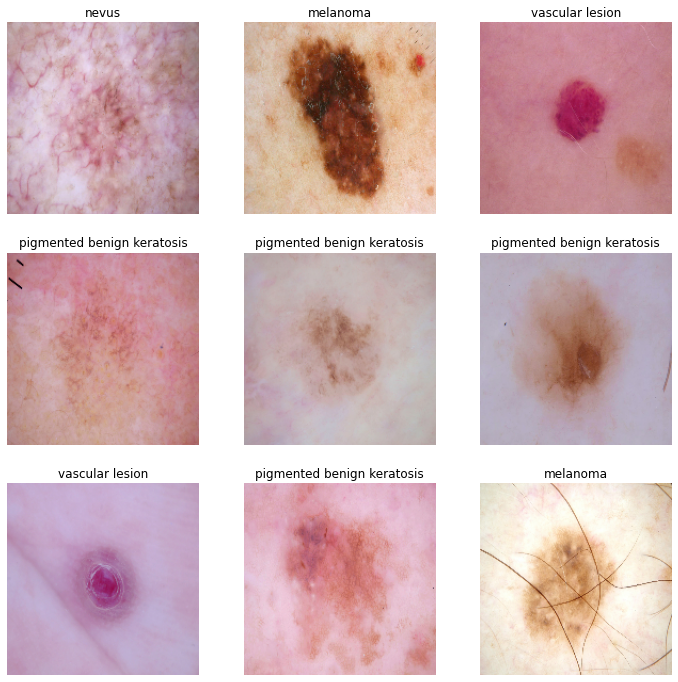

In [ ]:
## calling the function defined above for visualizing one class from each category
visual()

## Creating our model again after augmenting
 * we will also use dropouts here to reduce the overhit

In [ ]:
## Creating our second model
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.45))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(9))
model.add(Activation('softmax'))

In [ ]:
## printing summary to check for trainable parameters
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_51 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_52 (ModuleWr  (None, 180, 180, 32)     0         
 apper)                                                          
                                                                 
 module_wrapper_53 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                                 
 module_wrapper_54 (ModuleWr  (None, 90, 90, 32)       9248      
 apper)                                               

In [ ]:
## compiling the model again
compile_model()

In [ ]:
## fitting the model again
model_train = model.fit(train_dataset,
  batch_size=batch_size,
  validation_data=val_dataset,
  epochs=20)

Epoch 1/20
56/56 [==============================] - 15s 231ms/step - loss: 2.1254 - accuracy: 0.2333 - val_loss: 1.9823 - val_accuracy: 0.2729
Epoch 2/20
56/56 [==============================] - 14s 226ms/step - loss: 1.9712 - accuracy: 0.2522 - val_loss: 1.8746 - val_accuracy: 0.3110
Epoch 3/20
56/56 [==============================] - 14s 226ms/step - loss: 1.8048 - accuracy: 0.3393 - val_loss: 1.7468 - val_accuracy: 0.3266
Epoch 4/20
56/56 [==============================] - 14s 230ms/step - loss: 1.6994 - accuracy: 0.3633 - val_loss: 1.7410 - val_accuracy: 0.3803
Epoch 5/20
56/56 [==============================] - 14s 226ms/step - loss: 1.6613 - accuracy: 0.3890 - val_loss: 1.5294 - val_accuracy: 0.4609
Epoch 6/20
56/56 [==============================] - 14s 225ms/step - loss: 1.5880 - accuracy: 0.4163 - val_loss: 1.5465 - val_accuracy: 0.4586
Epoch 7/20
56/56 [==============================] - 14s 224ms/step - loss: 1.5189 - accuracy: 0.4581 - val_loss: 1.5626 - val_accuracy: 0.4072

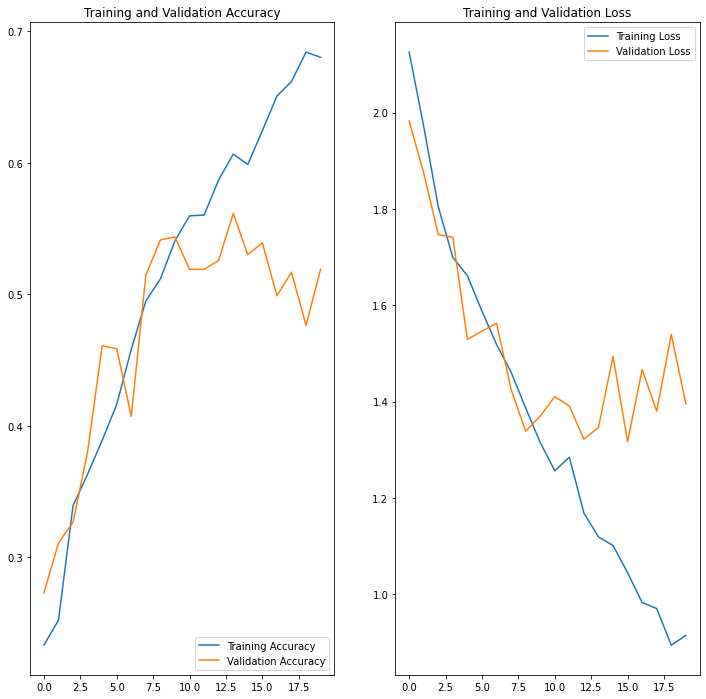

In [ ]:
## visualizing the accurcay/loss for training and validation dataset
validation_training()

### Conclusion Model 2
#### We can see that using dropout has reduced our overfitting but at the same time our overall accuracy has gone down

In [ ]:
## printing the accurcay and loss 
evaluate()

14/14 [==============================] - 3s 77ms/step - loss: 1.3956 - accuracy: 0.5190
Train Dataset Accuracy:  0.734375
Validation Dataset Accuracy:  0.5190156698226929
Train Dataset Loss:  0.7448143362998962
Validation Dataset Loss 1.3956341743469238


#### Many times in real world data we see a class imbalance let us check if we have class imbalance in our dataset as well

In [ ]:
## Checking each category data to see if there is a dominance of one over the other
for i in class_names:
  print(i, " : ", len(list(data_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis  :  114
basal cell carcinoma  :  376
dermatofibroma  :  95
melanoma  :  438
nevus  :  357
pigmented benign keratosis  :  462
seborrheic keratosis  :  77
squamous cell carcinoma  :  181
vascular lesion  :  139


#### We can clearly see that certain classes like (melanoma,pigmented benign keratosis, basal cell carcinoma) are dominant over the another hence there is class imbalance present in the data

<Figure size 576x864 with 0 Axes>

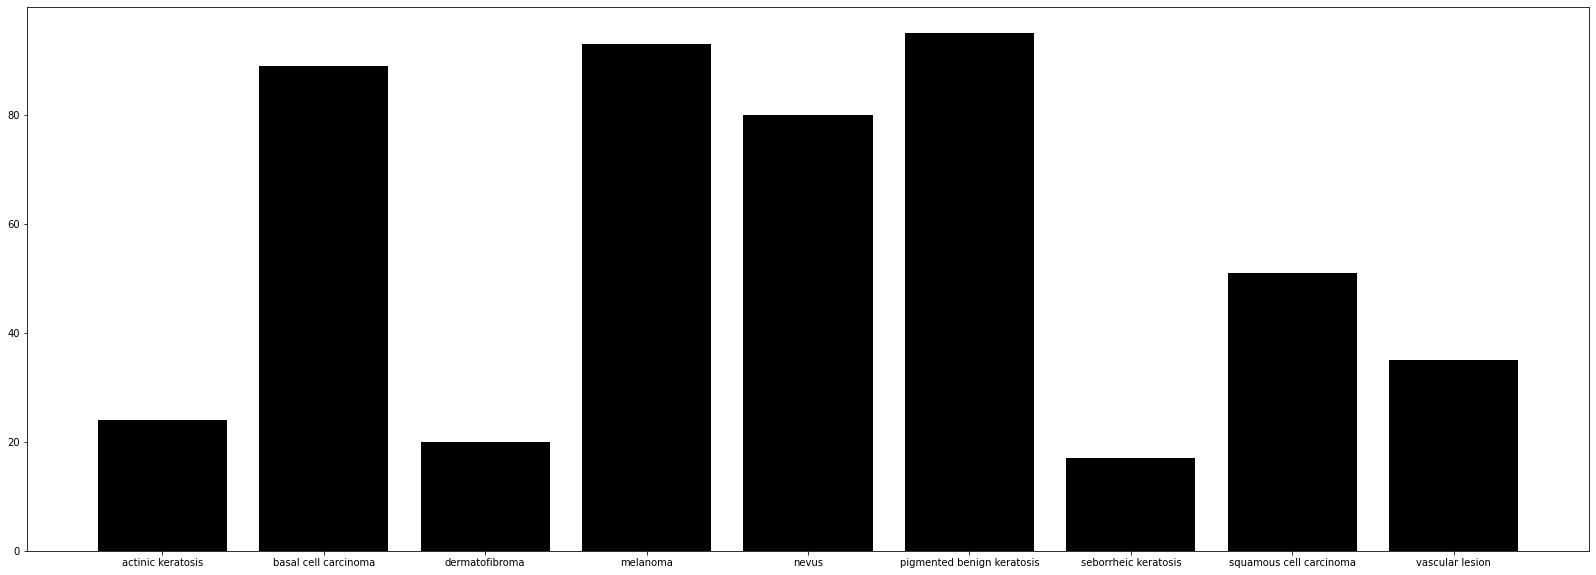

In [ ]:
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(8, 12))
for images, labels in train_ds:
  for i in range(len(class_names)):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

a = plt.figure()
a.set_figwidth(28)
a.set_figheight(10)

plt.bar(range(len(data)), list(data.values()), align='center', color='black')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

## It is evident from the above analysis that there is class imbalance in the data
* __seborrheic keratosis__ has the least samples i.e 77
* __melanoma,pigmented benign keratosis, basal cell carcinoma__ are the dominant classes


## Fixing Class Imbalance

In [ ]:
!pip install Augmentor

In [ ]:
path_to_training_dataset=base_path + "/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/Datasets/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0E9E3A2CD0>: 100%|██████████| 500/500 [00:19<00:00, 25.71 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/Datasets/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0EB6040E10>: 100%|██████████| 500/500 [00:21<00:00, 23.05 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/Datasets/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0EB618D510>: 100%|██████████| 500/500 [00:26<00:00, 19.21 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/Datasets/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F0E9E385D10>: 100%|██████████| 500/500 [01:42<00:00,  4.87 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/Datasets/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7F0EB606A750>: 100%|██████████| 500/500 [01:19<00:00,  6.25 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/Datasets/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0EB60F5CD0>: 100%|██████████| 500/500 [00:19<00:00, 26.20 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/Datasets/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0F200AE650>: 100%|██████████| 500/500 [00:44<00:00, 11.35 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/Datasets/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0E9E3DFD50>: 100%|██████████| 500/500 [00:19<00:00, 25.80 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/Datasets/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0EB60F2B10>: 100%|██████████| 500/500 [00:19<00:00, 25.71 Samples/s]


In [ ]:
image_count_train = len(list(data_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


###### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Colab_Notebooks/Datasets/Train/melanoma/output/melanoma_original_ISIC_0000278.jpg_bce5c3a8-49d1-476f-96ce-fc18e3ddfaf0.jpg',
 '/content/drive/MyDrive/Colab_Notebooks/Datasets/Train/melanoma/output/melanoma_original_ISIC_0010730.jpg_79df3635-daf6-499e-864d-bf074393cf46.jpg',
 '/content/drive/MyDrive/Colab_Notebooks/Datasets/Train/melanoma/output/melanoma_original_ISIC_0011178.jpg_50b1d444-39cd-4ba4-b7ce-c32dbf7f0a2c.jpg',
 '/content/drive/MyDrive/Colab_Notebooks/Datasets/Train/melanoma/output/melanoma_original_ISIC_0010466.jpg_a21eed0f-e014-41c8-a31a-b956f1869aea.jpg',
 '/content/drive/MyDrive/Colab_Notebooks/Datasets/Train/melanoma/output/melanoma_original_ISIC_0000297.jpg_82669915-65c1-4ca0-baff-9e2a04c2c0d6.jpg',
 '/content/drive/MyDrive/Colab_Notebooks/Datasets/Train/melanoma/output/melanoma_original_ISIC_0000531.jpg_026e5c56-17ae-4c3d-9a6f-0cd5f8fab6a8.jpg',
 '/content/drive/MyDrive/Colab_Notebooks/Datasets/Train/melanoma/output/melanoma_original_ISIC_00003

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
import glob
path_list_temp = [x for x in glob.glob(os.path.join(data_train, '*', '*.jpg'))]
lesson_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list_temp, lesson_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
## checking the value counts of each category after adding images
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

##### So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
## creating new training dataset
train_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
  data_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
## creating new validation dataset
val_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
  data_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Creating our final model
* we will use batchnormalization with dropout to improve our accuracy

In [ ]:
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.45))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(9))
model.add(Activation('softmax'))

In [ ]:
## compiling model 
compile_model()

In [ ]:
## displaying model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_87 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_88 (ModuleWr  (None, 180, 180, 32)     0         
 apper)                                                          
                                                                 
 batch_normalization_3 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 module_wrapper_89 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                               

In [ ]:
## fitting our final model
model_train = model.fit(
  train_ds_new,
  validation_data=val_ds_new,
  batch_size=batch_size,
  epochs=30)

Epoch 1/30
169/169 [==============================] - 31s 174ms/step - loss: 2.3706 - accuracy: 0.3357 - val_loss: 3.8066 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 31s 175ms/step - loss: 1.6287 - accuracy: 0.4097 - val_loss: 3.8189 - val_accuracy: 0.1878
Epoch 3/30
169/169 [==============================] - 31s 177ms/step - loss: 1.4584 - accuracy: 0.4618 - val_loss: 1.8996 - val_accuracy: 0.3786
Epoch 4/30
169/169 [==============================] - 30s 171ms/step - loss: 1.3507 - accuracy: 0.5026 - val_loss: 1.5577 - val_accuracy: 0.4551
Epoch 5/30
169/169 [==============================] - 30s 171ms/step - loss: 1.2034 - accuracy: 0.5573 - val_loss: 1.2460 - val_accuracy: 0.5583
Epoch 6/30
169/169 [==============================] - 30s 173ms/step - loss: 1.0655 - accuracy: 0.6070 - val_loss: 1.1894 - val_accuracy: 0.5612
Epoch 7/30
169/169 [==============================] - 30s 170ms/step - loss: 0.9417 - accuracy: 0.6456 - val_loss: 1.0508 - val_ac

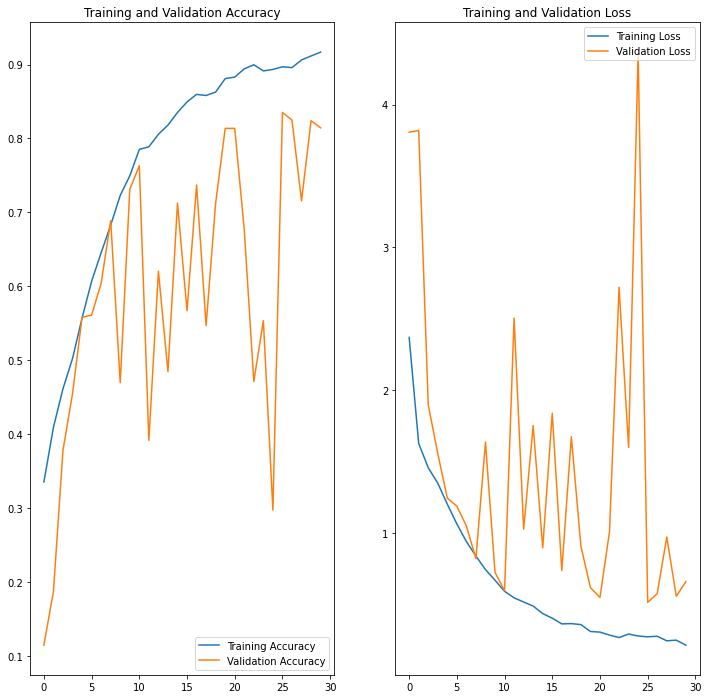

In [ ]:
## plotting accuracy and loss for the new train and validation dataset
epochs=30
acc = model_train.history['accuracy']
val_acc = model_train.history['val_accuracy']

loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
## calculating loss/accuracy for train and validation data for our last model
loss, accuracy = model.evaluate(train_ds_new, verbose=1,)
loss_val, accuracy_val = model.evaluate(val_ds_new, verbose=1)

print("Train Dataset Accuracy: ", accuracy)
print("Validation Dataset Accuracy: ",accuracy_val)
print("Train Dataset Loss: ",loss)
print("Validation Dataset Loss", loss_val)

43/43 [==============================] - 6s 112ms/step - loss: 0.6614 - accuracy: 0.8144
Train Dataset Accuracy:  0.9020771384239197
Validation Dataset Accuracy:  0.8144024014472961
Train Dataset Loss:  0.290831983089447
Validation Dataset Loss 0.661390483379364


## We can clearly see our first model was an overfit where training and validation had a big gap
## Our second model with some randomization on the images reduced the overfit but the accuracy went down
## Finally in our last model by handling class imbalance we were able to achieve a significant good model that handles overfitting as well as gives decent accuracy